# Imports

In [1]:
import os
import torch
import torch.nn as nn # Neural Network
import torch.optim as optim # Optimizer's Relu etc. 
from torch.utils.data import Dataset, DataLoader # Preprocessing Dataset, Loading Dataset

from PIL import Image # Open Image
import torchvision.transforms as transforms # Image Processing & Augmentation i.e. Resize, Flip, Normalize etc. 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity # Measures Similarity Between Vectors 
import pandas as pd
import seaborn as sns

In [2]:
df_images = pd.read_csv('/kaggle/input/fashion-product-images-dataset/fashion-dataset/images.csv')
df_styles = pd.read_csv(
    '/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv',
    on_bad_lines='skip',
    encoding='utf-8'
)

In [116]:
print(f'Images Table', df_images.columns)
print(f'Styles Table', df_styles.columns)

Images Table Index(['filename', 'link'], dtype='object')
Styles Table Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')


In [117]:
df_styles['masterCategory'].unique()

array(['Apparel', 'Accessories', 'Footwear', 'Personal Care',
       'Free Items', 'Sporting Goods', 'Home'], dtype=object)

In [5]:
df_styles['subCategory'].unique()

array(['Topwear', 'Bottomwear', 'Watches', 'Socks', 'Shoes', 'Belts',
       'Flip Flops', 'Bags', 'Innerwear', 'Sandal', 'Shoe Accessories',
       'Fragrance', 'Jewellery', 'Lips', 'Saree', 'Eyewear', 'Nails',
       'Scarves', 'Dress', 'Loungewear and Nightwear', 'Wallets',
       'Apparel Set', 'Headwear', 'Mufflers', 'Skin Care', 'Makeup',
       'Free Gifts', 'Ties', 'Accessories', 'Skin', 'Beauty Accessories',
       'Water Bottle', 'Eyes', 'Bath and Body', 'Gloves',
       'Sports Accessories', 'Cufflinks', 'Sports Equipment', 'Stoles',
       'Hair', 'Perfumes', 'Home Furnishing', 'Umbrellas', 'Wristbands',
       'Vouchers'], dtype=object)

In [6]:
df_styles['masterCategory']
df_masterCategory_OnlyApparel = df_styles[df_styles['masterCategory']=='Apparel']

In [7]:
df_masterCategory_OnlyApparel

id gender masterCategory subCategory  articleType baseColour  \
0      15970    Men        Apparel     Topwear       Shirts  Navy Blue   
1      39386    Men        Apparel  Bottomwear        Jeans       Blue   
3      21379    Men        Apparel  Bottomwear  Track Pants      Black   
4      53759    Men        Apparel     Topwear      Tshirts       Grey   
5       1855    Men        Apparel     Topwear      Tshirts       Grey   
...      ...    ...            ...         ...          ...        ...   
44414  30614    Men        Apparel     Topwear      Tshirts      Black   
44415  13496    Men        Apparel     Topwear      Tshirts       Blue   
44417  12544  Women        Apparel     Topwear      Tshirts      Peach   
44418  42234  Women        Apparel     Topwear         Tops       Blue   
44421  18842    Men        Apparel     Topwear      Tshirts       Blue   

       season    year   usage                             productDisplayName  
0        Fall  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1      Summer  2012.0  Casual             Peter England Men Party Blue Jeans  
3        Fall  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4      Summer  2012.0  Casual                          Puma Men Grey T-shirt  
5      Summer  2011.0  Casual           Inkfruit Mens Chain Reaction T-shirt  
...       ...     ...     ...                                            ...  
44414  Summer  2012.0  Sports                  Nike Men Striped Black Jersey  
44415    Fall  2011.0  Casual          Chimp Men Teja Main Hoon Blue Tshirts  
44417    Fall  2011.0  Casual             Tantra Women Printed Peach T-shirt  
44418  Summer  2012.0  Casual                   Sepia Women Blue Printed Top  
44421    Fall  2011.0  Casual           Puma Men Graphic Stellar Blue Tshirt  

[21397 rows x 10 columns]

In [8]:
df_masterCategory_OnlyApparel['subCategory'].unique()

array(['Topwear', 'Bottomwear', 'Innerwear', 'Saree', 'Dress',
       'Loungewear and Nightwear', 'Apparel Set', 'Socks'], dtype=object)

In [9]:
# df_masterCategory_OnlyApparel['subCategory'] == df_styles['Bottomwear']
df_subCategory_OnlyApparel_Bottomwear = df_masterCategory_OnlyApparel['subCategory']

In [10]:
df_styles.head()

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt

In [11]:
df_updated_styles = df_styles[df_styles['gender'].isin(['Men', 'Women'])]
df_updated_styles

id gender masterCategory subCategory            articleType  \
0      15970    Men        Apparel     Topwear                 Shirts   
1      39386    Men        Apparel  Bottomwear                  Jeans   
2      59263  Women    Accessories     Watches                Watches   
3      21379    Men        Apparel  Bottomwear            Track Pants   
4      53759    Men        Apparel     Topwear                Tshirts   
...      ...    ...            ...         ...                    ...   
44419  17036    Men       Footwear       Shoes           Casual Shoes   
44420   6461    Men       Footwear  Flip Flops             Flip Flops   
44421  18842    Men        Apparel     Topwear                Tshirts   
44422  46694  Women  Personal Care   Fragrance  Perfume and Body Mist   
44423  51623  Women    Accessories     Watches                Watches   

      baseColour  season    year   usage  \
0      Navy Blue    Fall  2011.0  Casual   
1           Blue  Summer  2012.0  Casual   
2         Silver  Winter  2016.0  Casual   
3          Black    Fall  2011.0  Casual   
4           Grey  Summer  2012.0  Casual   
...          ...     ...     ...     ...   
44419      White  Summer  2013.0  Casual   
44420        Red  Summer  2011.0  Casual   
44421       Blue    Fall  2011.0  Casual   
44422       Blue  Spring  2017.0  Casual   
44423       Pink  Winter  2016.0  Casual   

                                    productDisplayName  
0                     Turtle Check Men Navy Blue Shirt  
1                   Peter England Men Party Blue Jeans  
2                             Titan Women Silver Watch  
3        Manchester United Men Solid Black Track Pants  
4                                Puma Men Grey T-shirt  
...                                                ...  
44419                        Gas Men Caddy Casual Shoe  
44420               Lotto Men's Soccer Track Flip Flop  
44421             Puma Men Graphic Stellar Blue Tshirt  
44422                   Rasasi Women Blue Lady Perfume  
44423  Fossil Women Pink Dial Chronograph Watch ES3050  

[40778 rows x 10 columns]

In [12]:
df_images.head()

filename                                               link
0  15970.jpg  http://assets.myntassets.com/v1/images/style/p...
1  39386.jpg  http://assets.myntassets.com/v1/images/style/p...
2  59263.jpg  http://assets.myntassets.com/v1/images/style/p...
3  21379.jpg  http://assets.myntassets.com/v1/images/style/p...
4  53759.jpg  http://assets.myntassets.com/v1/images/style/p...

In [13]:
df_images.columns

Index(['filename', 'link'], dtype='object')

In [14]:
# Quick overview
print("Number of products in styles.csv:", len(df_styles))
print("Number of images in images.csv:", len(df_images))

Number of products in styles.csv: 44424
Number of images in images.csv: 44446


In [15]:
print("Styles CSV Shape", df_styles.shape)
print("Images CSV Shape", df_images.shape)

Styles CSV Shape (44424, 10)
Images CSV Shape (44446, 2)


# Exploratory Data Analysis

In [16]:
total_products = df_styles['id'].nunique()
print("Total unique products:", total_products)


Total unique products: 44424


# Merging Image with Meta Data

In [17]:
# Total images
df = df_styles
print("Total images:", len(df))

# Number of unique categories
print("Master categories:", df['masterCategory'].nunique())
print("Subcategories:", df['subCategory'].nunique())
print("Article types:", df['articleType'].nunique())
print("Colors:", df['baseColour'].nunique())


Total images: 44424
Master categories: 7
Subcategories: 45
Article types: 143
Colors: 46


In [118]:
df

id gender masterCategory subCategory            articleType  \
0      15970    Men        Apparel     Topwear                 Shirts   
1      39386    Men        Apparel  Bottomwear                  Jeans   
2      59263  Women    Accessories     Watches                Watches   
3      21379    Men        Apparel  Bottomwear            Track Pants   
4      53759    Men        Apparel     Topwear                Tshirts   
...      ...    ...            ...         ...                    ...   
44419  17036    Men       Footwear       Shoes           Casual Shoes   
44420   6461    Men       Footwear  Flip Flops             Flip Flops   
44421  18842    Men        Apparel     Topwear                Tshirts   
44422  46694  Women  Personal Care   Fragrance  Perfume and Body Mist   
44423  51623  Women    Accessories     Watches                Watches   

      baseColour  season    year   usage  \
0      Navy Blue    Fall  2011.0  Casual   
1           Blue  Summer  2012.0  Casual   
2         Silver  Winter  2016.0  Casual   
3          Black    Fall  2011.0  Casual   
4           Grey  Summer  2012.0  Casual   
...          ...     ...     ...     ...   
44419      White  Summer  2013.0  Casual   
44420        Red  Summer  2011.0  Casual   
44421       Blue    Fall  2011.0  Casual   
44422       Blue  Spring  2017.0  Casual   
44423       Pink  Winter  2016.0  Casual   

                                    productDisplayName  
0                     Turtle Check Men Navy Blue Shirt  
1                   Peter England Men Party Blue Jeans  
2                             Titan Women Silver Watch  
3        Manchester United Men Solid Black Track Pants  
4                                Puma Men Grey T-shirt  
...                                                ...  
44419                        Gas Men Caddy Casual Shoe  
44420               Lotto Men's Soccer Track Flip Flop  
44421             Puma Men Graphic Stellar Blue Tshirt  
44422                   Rasasi Women Blue Lady Perfume  
44423  Fossil Women Pink Dial Chronograph Watch ES3050  

[44424 rows x 10 columns]

# Class Distribution (Master Category)

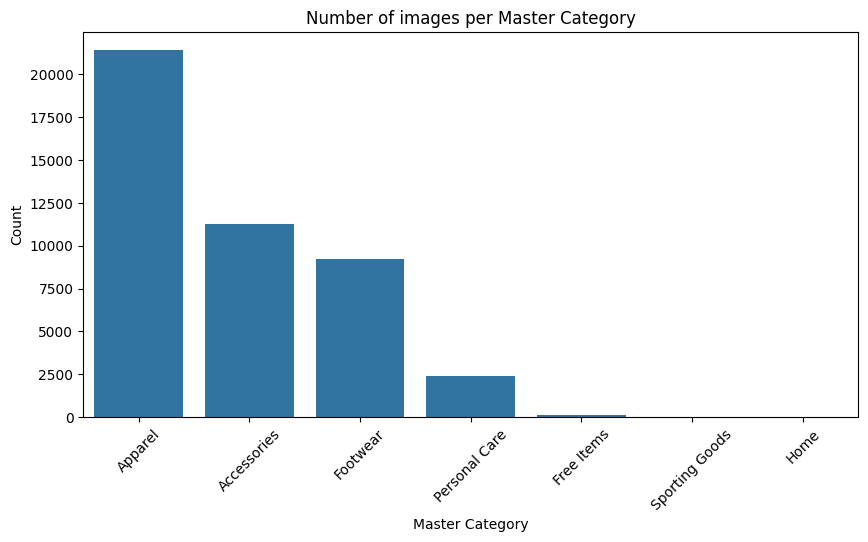

In [18]:
# Count images per masterCategory
category_counts = df['masterCategory'].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title("Number of images per Master Category")
plt.ylabel("Count")
plt.xlabel("Master Category")
plt.xticks(rotation=45)
plt.show()

# Subcategory Distribution

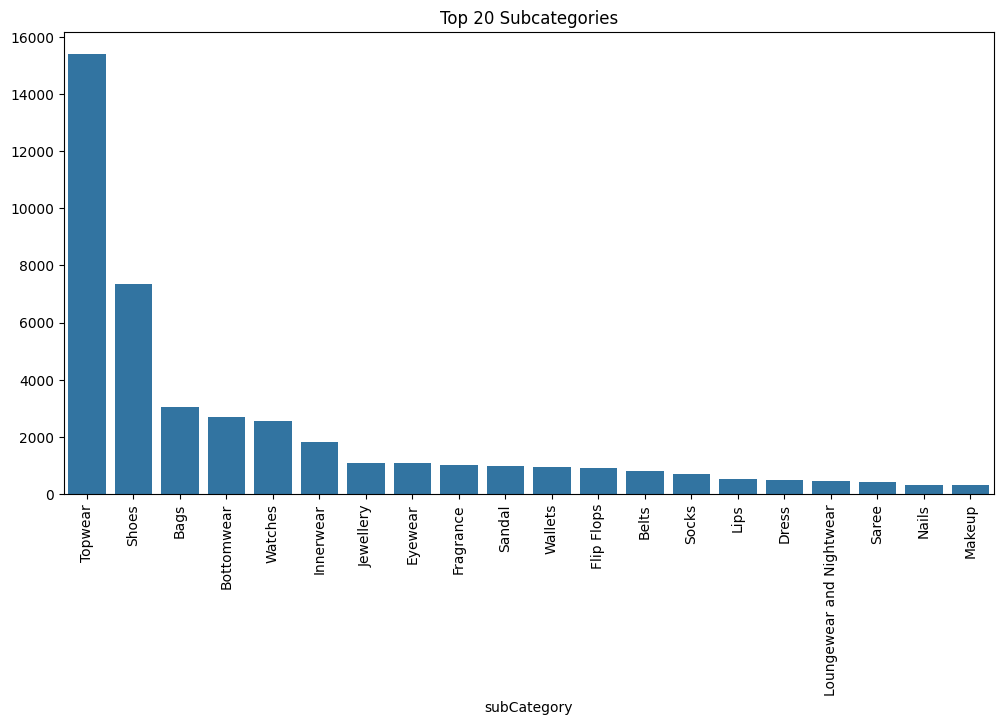

In [19]:
# Top 20 subcategories
sub_counts = df['subCategory'].value_counts().head(20)

plt.figure(figsize=(12,6))
sns.barplot(x=sub_counts.index, y=sub_counts.values)
plt.title("Top 20 Subcategories")
plt.xticks(rotation=90)
plt.show()

# Color distribution

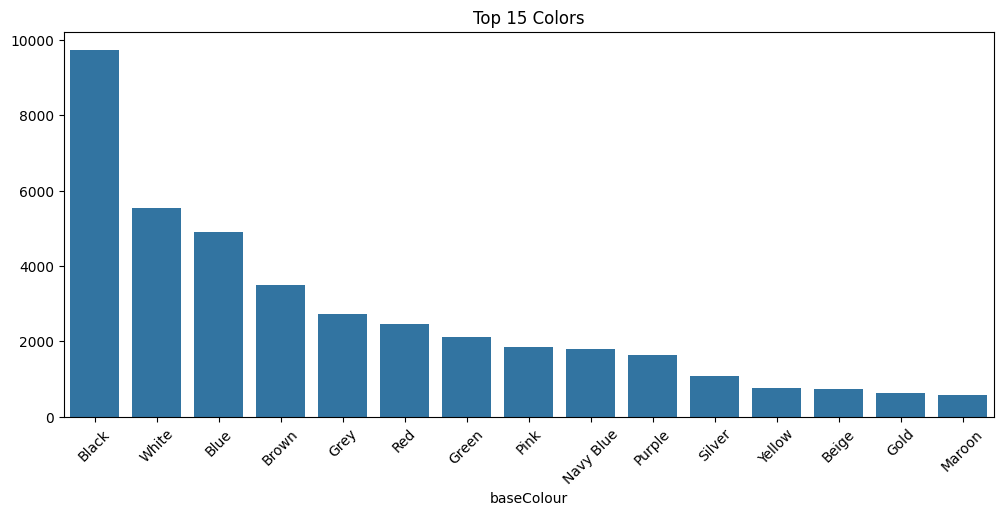

In [20]:
color_counts = df['baseColour'].value_counts().head(15)

plt.figure(figsize=(12,5))
sns.barplot(x=color_counts.index, y=color_counts.values)
plt.title("Top 15 Colors")
plt.xticks(rotation=45)
plt.show()


# Number of Images Per Master Category

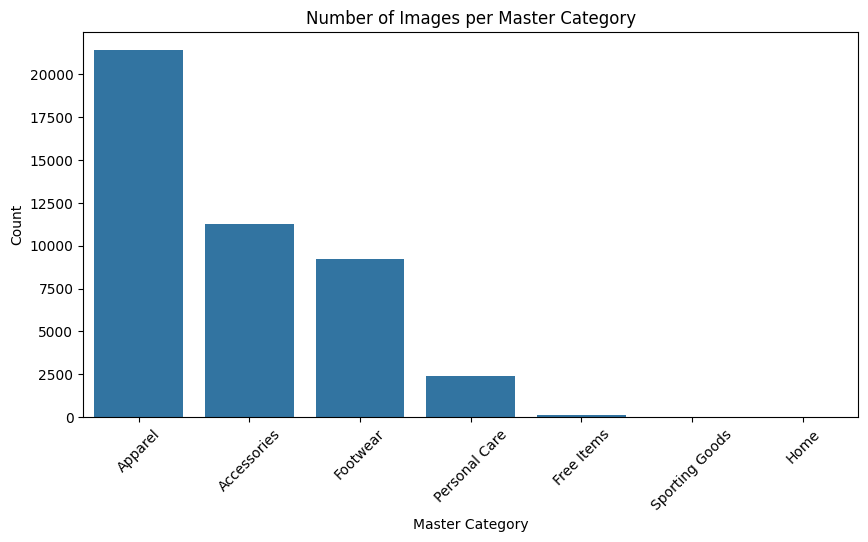

In [21]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='masterCategory', order=df['masterCategory'].value_counts().index)
plt.title("Number of Images per Master Category")
plt.ylabel("Count")
plt.xlabel("Master Category")
plt.xticks(rotation=45)
plt.show()


# Number of Images per sub category

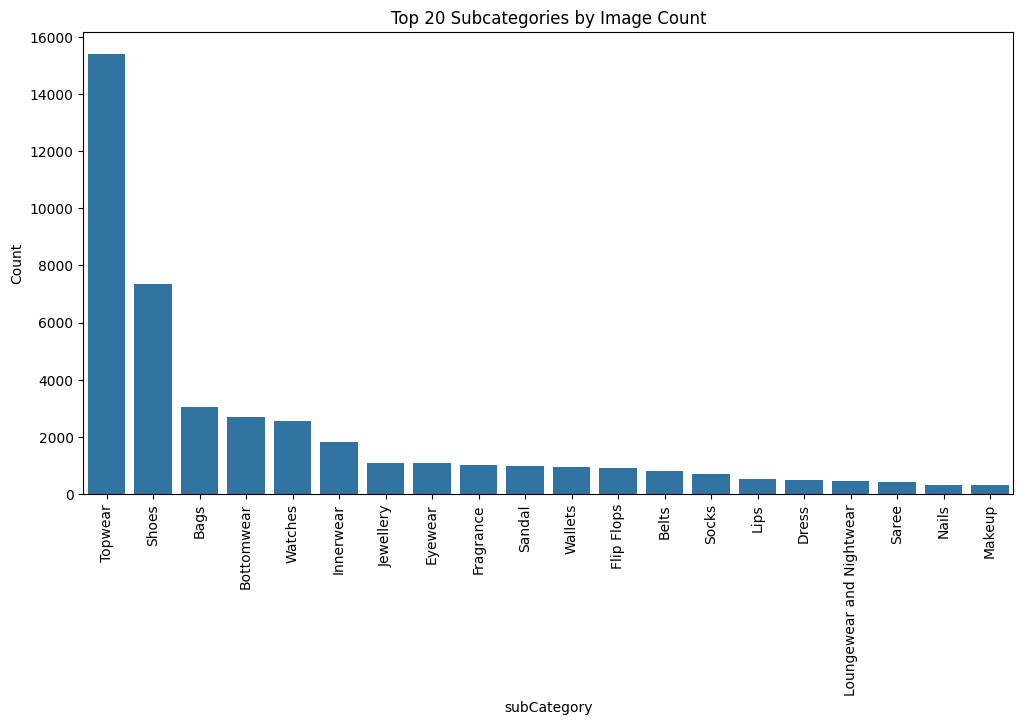

In [22]:
top_subcategories = df['subCategory'].value_counts().head(20)
plt.figure(figsize=(12,6))
sns.barplot(x=top_subcategories.index, y=top_subcategories.values)
plt.title("Top 20 Subcategories by Image Count")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.show()

# Color distribution (top 15)

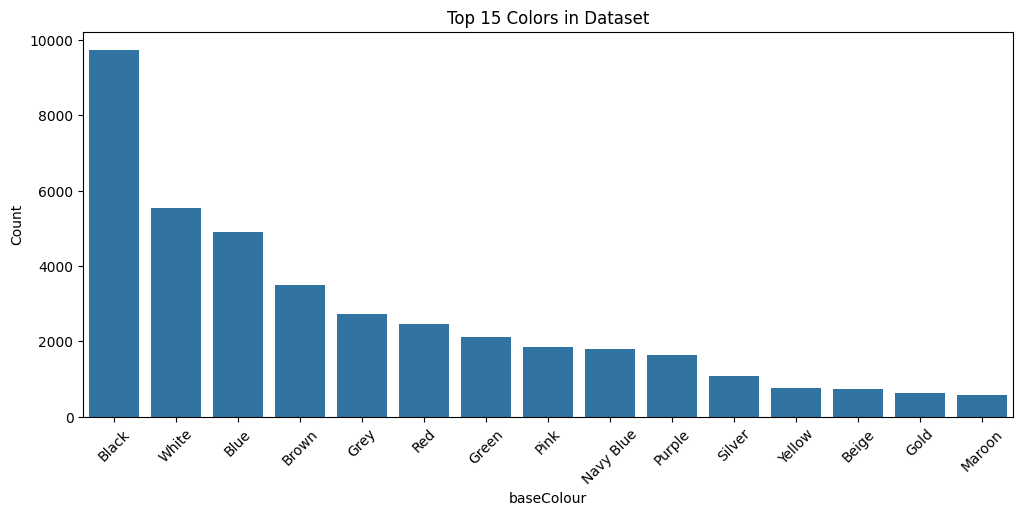

In [23]:
top_colors = df['baseColour'].value_counts().head(15)
plt.figure(figsize=(12,5))
sns.barplot(x=top_colors.index, y=top_colors.values)
plt.title("Top 15 Colors in Dataset")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()


# Images per gender

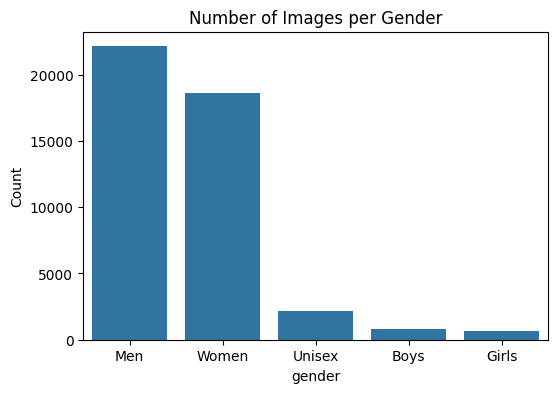

In [24]:
gender_counts = df['gender'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=gender_counts.index, y=gender_counts.values)
plt.title("Number of Images per Gender")
plt.ylabel("Count")
plt.show()


# Category vs. Gender Heatmap

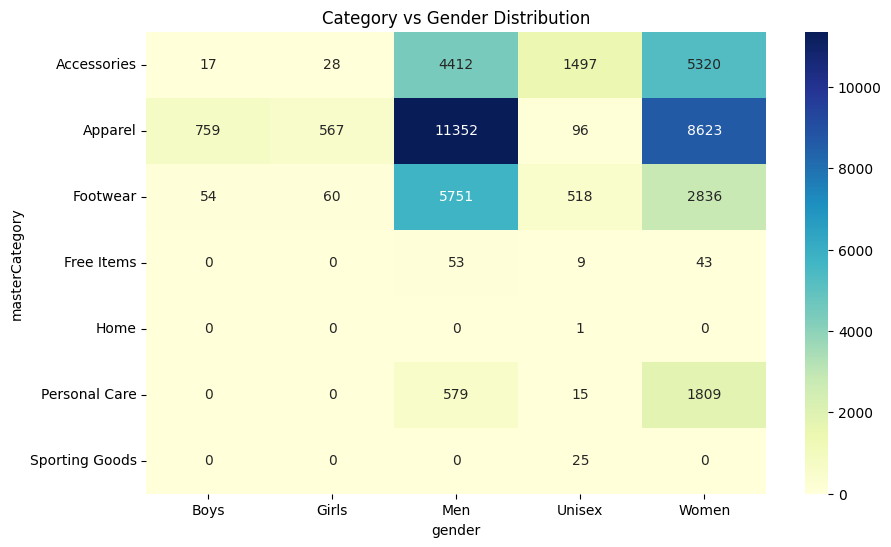

In [25]:
category_gender = pd.crosstab(df['masterCategory'], df['gender'])
plt.figure(figsize=(10,6))
sns.heatmap(category_gender, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Category vs Gender Distribution")
plt.show()


# Subcategory vs. Color Heatmap (top 20 subcategories)

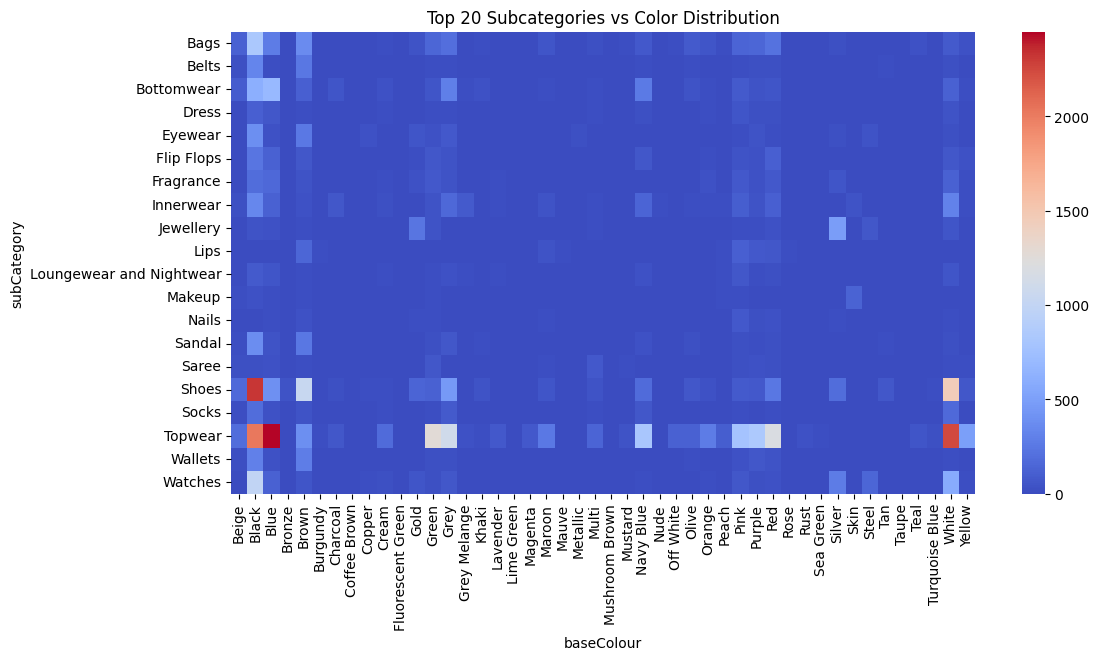

In [26]:
top_subs = df['subCategory'].value_counts().head(20).index
df_top = df[df['subCategory'].isin(top_subs)]

sub_color = pd.crosstab(df_top['subCategory'], df_top['baseColour'])
plt.figure(figsize=(12,6))
sns.heatmap(sub_color, cmap="coolwarm", annot=False)
plt.title("Top 20 Subcategories vs Color Distribution")
plt.show()


In [27]:
subcategory_counts = df_styles['subCategory'].value_counts()
subcategory_counts.head(10)


subCategory
Topwear       15402
Shoes          7343
Bags           3055
Bottomwear     2694
Watches        2542
Innerwear      1808
Jewellery      1079
Eyewear        1073
Fragrance      1011
Sandal          963
Name: count, dtype: int64

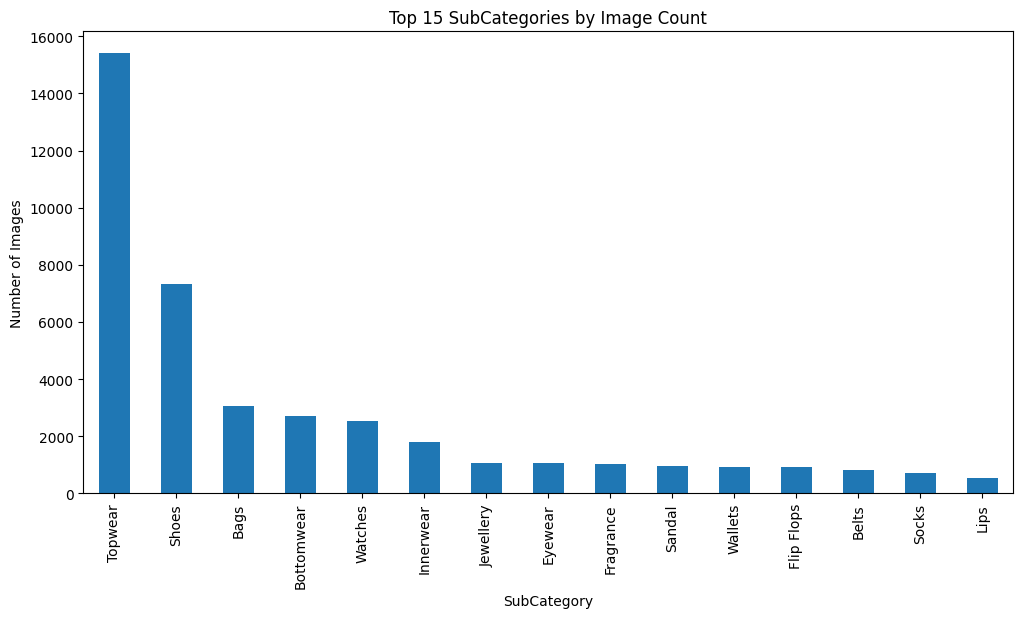

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
subcategory_counts[:15].plot(kind='bar')
plt.title("Top 15 SubCategories by Image Count")
plt.ylabel("Number of Images")
plt.xlabel("SubCategory")
plt.show()


# Filter Dataset (Top SubCategories) 

In [140]:
TOP_CATEGORIES = [
    'Topwear', 'Shoes', 'Bags', 'Bottomwear', 'Watches',
    'Innerwear', 'Jewellery', 'Eyewear', 'Fragrance', 'Sandal'
]

df_final = df[df['subCategory'].isin(TOP_CATEGORIES)].reset_index(drop=True)

print("Final dataset size:", df_final.shape)
df_final['subCategory'].value_counts()


Final dataset size: (36970, 10)


subCategory
Topwear       15402
Shoes          7343
Bags           3055
Bottomwear     2694
Watches        2542
Innerwear      1808
Jewellery      1079
Eyewear        1073
Fragrance      1011
Sandal          963
Name: count, dtype: int64

In [167]:
print(df_images.shape)
print(df_styles.shape)

(44446, 3)
(44424, 10)


In [169]:
import pandas as pd

# Ensure 'id' exists
# df_images['id'] should already exist
df_images['id'] = df_images['filename'].str.replace('.jpg','',regex=False).astype(int)

# Merge styles + images
df_final = df_styles.merge(df_images[['id','filename']], on='id', how='inner')  # only keep matching rows

print("Merged dataset size:", df_final.shape)

# Filter top 10 subCategories
TOP_CATEGORIES = [
    'Topwear', 'Shoes', 'Bags', 'Bottomwear', 'Watches',
    'Innerwear', 'Jewellery', 'Eyewear', 'Fragrance', 'Sandal'
]

df_final = df_final[df_final['subCategory'].isin(TOP_CATEGORIES)].reset_index(drop=True)
print("After top 10 subCategory filter:", df_final.shape)

# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_final['label'] = label_encoder.fit_transform(df_final['subCategory'])

num_classes = df_final['label'].nunique()
print("Number of classes:", num_classes)

# Train/Val Split
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(
    df_final,
    test_size=0.2,
    stratify=df_final['label'],
    random_state=42
)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))

# Verify IMAGE_DIR and filenames
IMAGE_DIR = '/kaggle/input/fashion-product-images-dataset/images/'

print("Sample filenames:", train_df['filename'].head())
print("File exists check:", os.path.exists(os.path.join(IMAGE_DIR, train_df.iloc[0]['filename'])))


Merged dataset size: (44424, 11)
After top 10 subCategory filter: (36970, 11)
Number of classes: 10
Train size: 29576
Validation size: 7394
Sample filenames: 35296     1621.jpg
24000    14570.jpg
29226     7837.jpg
21752    48349.jpg
21840    34051.jpg
Name: filename, dtype: object
File exists check: False


In [172]:
import os

# Get list of all images in the Kaggle folder
available_images = set(os.listdir(IMAGE_DIR))

# Keep only rows with filenames that exist
df_final = df_final[df_final['filename'].isin(available_images)].reset_index(drop=True)

print("Dataset size after keeping only existing images:", df_final.shape)

# Train/Val split again
train_df, val_df = train_test_split(
    df_final,
    test_size=0.2,
    stratify=df_final['label'],
    random_state=42
)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))

# Quick check
print("Sample filenames:", train_df['filename'].head())
print("File exists check:", os.path.exists(os.path.join(IMAGE_DIR, train_df.iloc[0]['filename'])))


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/fashion-product-images-dataset/images/'

In [171]:
df_final

id gender masterCategory subCategory            articleType  \
0      15970    Men        Apparel     Topwear                 Shirts   
1      39386    Men        Apparel  Bottomwear                  Jeans   
2      59263  Women    Accessories     Watches                Watches   
3      21379    Men        Apparel  Bottomwear            Track Pants   
4      53759    Men        Apparel     Topwear                Tshirts   
...      ...    ...            ...         ...                    ...   
36965  42234  Women        Apparel     Topwear                   Tops   
36966  17036    Men       Footwear       Shoes           Casual Shoes   
36967  18842    Men        Apparel     Topwear                Tshirts   
36968  46694  Women  Personal Care   Fragrance  Perfume and Body Mist   
36969  51623  Women    Accessories     Watches                Watches   

      baseColour  season    year   usage  \
0      Navy Blue    Fall  2011.0  Casual   
1           Blue  Summer  2012.0  Casual   
2         Silver  Winter  2016.0  Casual   
3          Black    Fall  2011.0  Casual   
4           Grey  Summer  2012.0  Casual   
...          ...     ...     ...     ...   
36965       Blue  Summer  2012.0  Casual   
36966      White  Summer  2013.0  Casual   
36967       Blue    Fall  2011.0  Casual   
36968       Blue  Spring  2017.0  Casual   
36969       Pink  Winter  2016.0  Casual   

                                    productDisplayName   filename  label  
0                     Turtle Check Men Navy Blue Shirt  15970.jpg      8  
1                   Peter England Men Party Blue Jeans  39386.jpg      1  
2                             Titan Women Silver Watch  59263.jpg      9  
3        Manchester United Men Solid Black Track Pants  21379.jpg      1  
4                                Puma Men Grey T-shirt  53759.jpg      8  
...                                                ...        ...    ...  
36965                     Sepia Women Blue Printed Top  42234.jpg      8  
36966                        Gas Men Caddy Casual Shoe  17036.jpg      7  
36967             Puma Men Graphic Stellar Blue Tshirt  18842.jpg      8  
36968                   Rasasi Women Blue Lady Perfume  46694.jpg      3  
36969  Fossil Women Pink Dial Chronograph Watch ES3050  51623.jpg      9  

[36970 rows x 12 columns]

## Merging the Datasets

In [149]:
# Extract product ID from filename
df_images['id'] = df_images['filename'].str.replace('.jpg', '', regex=False).astype(int)

# Check
df_images.head()



filename                                               link     id
0  15970.jpg  http://assets.myntassets.com/v1/images/style/p...  15970
1  39386.jpg  http://assets.myntassets.com/v1/images/style/p...  39386
2  59263.jpg  http://assets.myntassets.com/v1/images/style/p...  59263
3  21379.jpg  http://assets.myntassets.com/v1/images/style/p...  21379
4  53759.jpg  http://assets.myntassets.com/v1/images/style/p...  53759

In [150]:
df_final = df_final.merge(df_images[['id','filename']], on='id', how='left')

# Check
print(df_final.columns)
print(df_final[['id','filename','subCategory','label']].head())


Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'label',
       'filename'],
      dtype='object')
      id   filename subCategory  label
0  15970  15970.jpg     Topwear      8
1  39386  39386.jpg  Bottomwear      1
2  59263  59263.jpg     Watches      9
3  21379  21379.jpg  Bottomwear      1
4  53759  53759.jpg     Topwear      8


In [156]:
# Remove rows where filename is missing
df_final = df_final.dropna(subset=['filename']).reset_index(drop=True)

print("Dataset after keeping only available images:", df_final.shape)


Dataset after keeping only available images: (36970, 12)


## Encode Labels (VERY IMPORTANT)

In [141]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_final['label'] = label_encoder.fit_transform(df_final['subCategory'])

num_classes = df_final['label'].nunique()
print("Number of classes:", num_classes)


Number of classes: 10


## Train / Validation Split

In [157]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df_final,
    test_size=0.2,
    stratify=df_final['label'],
    random_state=42
)

print("Train size:", train_df.shape)
print("Val size:", val_df.shape)


Train size: (29576, 12)
Val size: (7394, 12)


## Image Generator From Scratch

In [158]:
def image_generator(df, image_dir, batch_size=BATCH_SIZE):
    while True:
        df = df.sample(frac=1).reset_index(drop=True)
        
        for i in range(0, len(df), batch_size):
            batch = df.iloc[i:i+batch_size]
            
            images = []
            labels = []
            
            for _, row in batch.iterrows():
                img_path = os.path.join(image_dir, row['filename'])

                # Load image
                img = tf.keras.preprocessing.image.load_img(
                    img_path, target_size=IMAGE_SIZE
                )
                img = tf.keras.preprocessing.image.img_to_array(img)
                img = img / 255.0   # normalize

                images.append(img)
                labels.append(row['label'])
            
            yield tf.convert_to_tensor(images), tf.convert_to_tensor(labels)


## Build CNN FROM SCRATCH

In [159]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu', name="embedding_layer"),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax')
])

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Dense)         │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,750,538 (10.49 MB)

 Trainable params: 2,750,538 (10.49 MB)

 Non-trainable params: 0 (0.00 B)

## Compiled Model

In [160]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


## Define the Image Dir once

In [134]:
IMAGE_DIR = '/kaggle/input/fashion-product-images-dataset/images/'


# Checking for missing files before training

In [162]:
import os

IMAGE_DIR = '/kaggle/input/fashion-product-images-dataset/images/'

missing_files = []
for fname in df_final['filename']:
    if not os.path.exists(os.path.join(IMAGE_DIR, fname)):
        missing_files.append(fname)

print("Number of missing files:", len(missing_files))


Number of missing files: 36970


## Train the CNN

In [161]:
EPOCHS = 15

train_gen = image_generator(train_df, IMAGE_DIR)
val_gen = image_generator(val_df, IMAGE_DIR)

history = model.fit(
    train_gen,
    steps_per_epoch=len(train_df)//BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=len(val_df)//BATCH_SIZE,
    epochs=EPOCHS
)


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/fashion-product-images-dataset/images/19303.jpg'

## QUICK SANITY CHECK (RUN THIS)

In [139]:
test_row = train_df.iloc[0]
test_path = os.path.join(IMAGE_DIR, test_row['filename'])

print("Image path:", test_path)
print("File exists:", os.path.exists(test_path))


KeyError: '/kaggle/input/fashion-product-images-dataset/'

In [147]:
print("Train DF columns:", train_df.columns)
print("First row:", train_df.iloc[0])

Train DF columns: Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'label'],
      dtype='object')
First row: id                                                       1621
gender                                                    Men
masterCategory                                        Apparel
subCategory                                        Bottomwear
articleType                                            Shorts
baseColour                                               Grey
season                                                   Fall
year                                                   2010.0
usage                                                  Sports
productDisplayName    Reebok Men Micro Shorts Black and White
label                                                       1
Name: 35296, dtype: object


# Filter Top Wear

In [29]:
topwear_df = df_styles[df_styles['subCategory'] == 'Topwear'].reset_index(drop=True)

print("Topwear images:", topwear_df.shape[0])


Topwear images: 15402


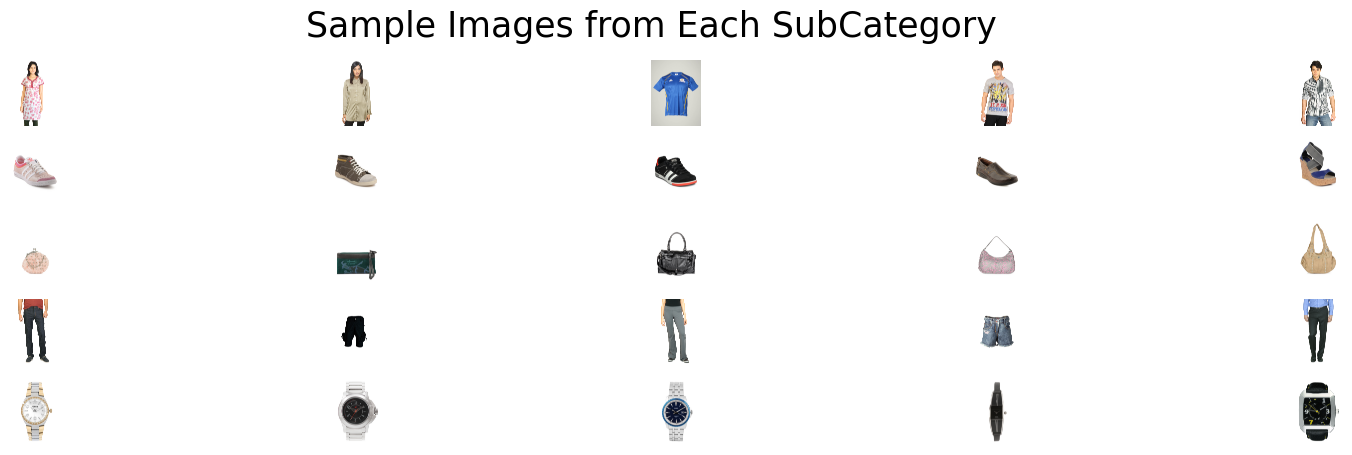

In [30]:
import matplotlib.pyplot as plt
from PIL import Image
import os

base_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset'
styles_df = df_styles
# Parameters
IMAGE_FOLDER = f"{base_path}/images"
top_n = 5  # number of images per subcategory
subcategories = ['Topwear', 'Shoes', 'Bags', 'Bottomwear', 'Watches']  # chosen for your project

plt.figure(figsize=(20, 5))

for i, subcat in enumerate(subcategories):
    sub_df = styles_df[styles_df['subCategory'] == subcat].sample(top_n, random_state=42)
    
    for j, row in enumerate(sub_df.itertuples()):
        plt.subplot(len(subcategories), top_n, i*top_n + j + 1)
        img_path = os.path.join(IMAGE_FOLDER, str(row.id) + ".jpg")
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis("off")
        if j == 0:
            plt.ylabel(subcat, fontsize=14)
plt.suptitle("Sample Images from Each SubCategory", fontsize=25)
plt.show()


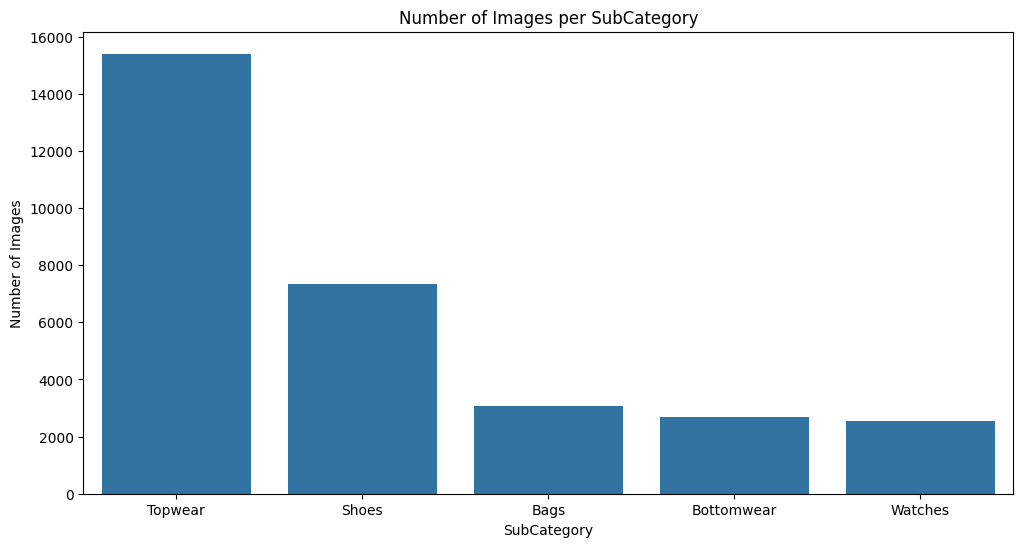

In [31]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x=subcategories, y=[styles_df[styles_df['subCategory']==sc].shape[0] for sc in subcategories])
plt.title("Number of Images per SubCategory")
plt.ylabel("Number of Images")
plt.xlabel("SubCategory")
plt.show()


# Filtering Top Wear Articles 

In [32]:
topwear_df = styles_df[styles_df['subCategory'] == 'Topwear']


In [33]:
topwear_counts = topwear_df['articleType'].value_counts()
topwear_counts.head(10)  # show top 10 for sanity check


articleType
Tshirts        7066
Shirts         3217
Kurtas         1844
Tops           1762
Sweatshirts     285
Sweaters        277
Jackets         258
Kurtis          234
Tunics          229
Dupatta         116
Name: count, dtype: int64

/tmp/ipykernel_55/3208533472.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10.index, y=top_10.values, palette="viridis")


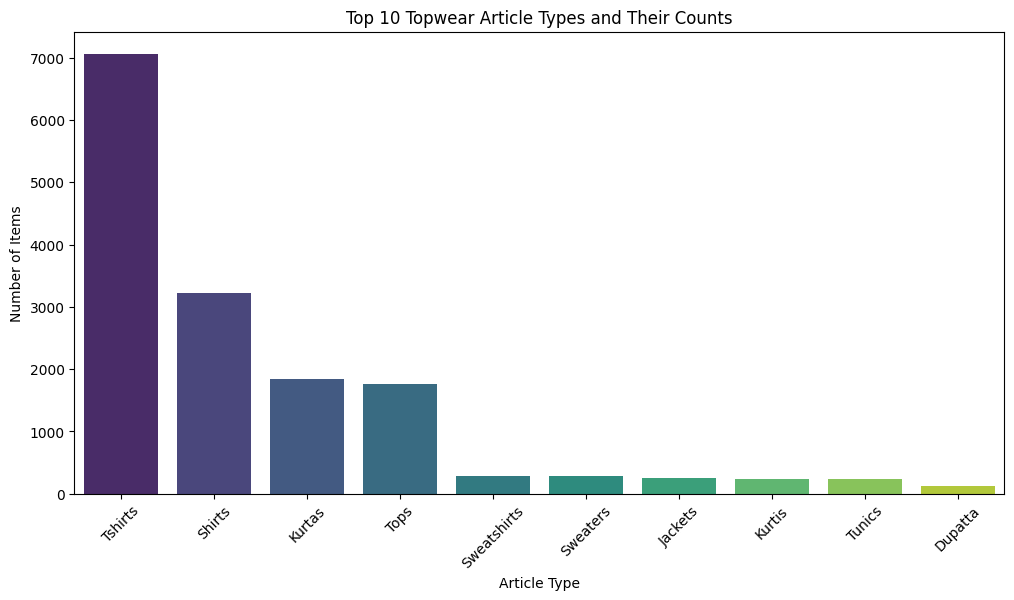

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Take top 10 article types
top_10 = topwear_counts[:10]

plt.figure(figsize=(12, 6))
sns.barplot(x=top_10.index, y=top_10.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Top 10 Topwear Article Types and Their Counts")
plt.xlabel("Article Type")
plt.ylabel("Number of Items")
plt.show()


# Filtering Top Wear Articles with respect to 'Gender'

In [35]:
topwear_gender_counts = topwear_df.groupby(['articleType', 'gender']).size().reset_index(name='count')
topwear_gender_counts.head(10)


articleType  gender  count
0       Belts     Men      3
1     Blazers    Boys      1
2     Blazers     Men      5
3     Blazers   Women      2
4     Dresses   Women      2
5     Dupatta   Women    116
6     Jackets    Boys      6
7     Jackets     Men    195
8     Jackets  Unisex      1
9     Jackets   Women     56

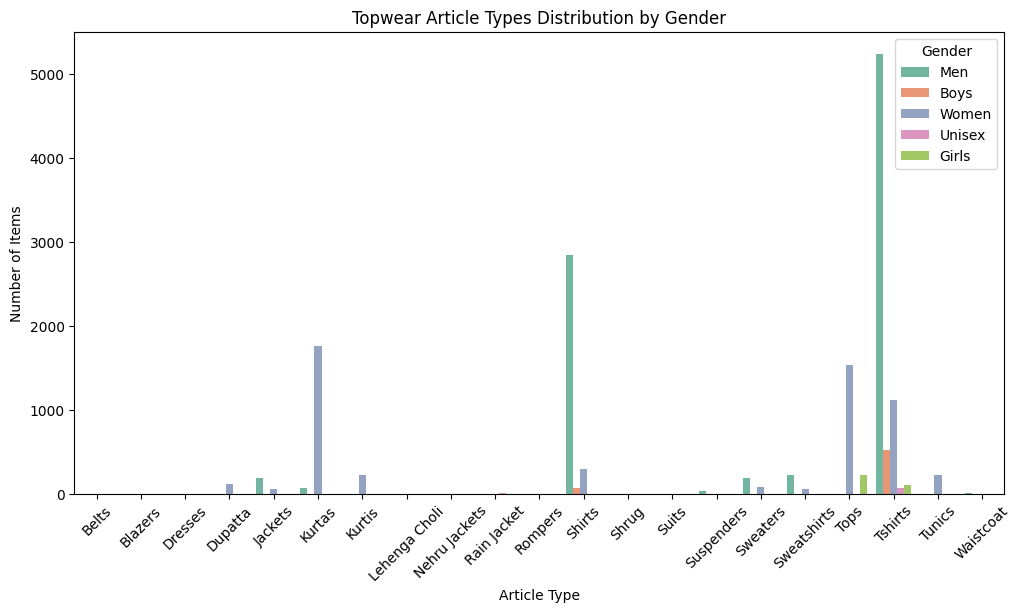

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=topwear_gender_counts, x='articleType', y='count', hue='gender', palette='Set2')
plt.xticks(rotation=45)
plt.title("Topwear Article Types Distribution by Gender")
plt.xlabel("Article Type")
plt.ylabel("Number of Items")
plt.legend(title='Gender')
plt.show()


# Train Test Validation Split
### Train 70% 
### Validation 15%
### Test 15%

In [37]:
from sklearn.model_selection import train_test_split

apparel_df = styles_df[
    styles_df['subCategory'].isin(['Topwear', 'Bottomwear'])
]

train_df, temp_df = train_test_split(
    apparel_df, test_size=0.3, stratify=apparel_df['subCategory'], random_state=42
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['subCategory'], random_state=42
)


In [38]:
import pandas as pd

base_path = "/kaggle/input/fashion-product-images-dataset/fashion-dataset"

styles_df = pd.read_csv(
    f"{base_path}/styles.csv",
    engine="python",
    on_bad_lines="skip"
)

print(styles_df.shape)
styles_df.head()



(44424, 10)


id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt

In [39]:
styles_df.columns


Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')

# Remove Missing Id's 

In [40]:
styles_df.dropna(subset=['id'], inplace=True)
styles_df['id'] = styles_df['id'].astype(int)


# Filter only Topwear & Bottomwear

In [41]:
apparel_df = styles_df[
    styles_df['subCategory'].isin(['Topwear', 'Bottomwear'])
].copy()

label_map = {'Topwear': 0, 'Bottomwear': 1}
apparel_df['label'] = apparel_df['subCategory'].map(label_map)
apparel_df['image'] = apparel_df['id'].astype(str) + ".jpg"

apparel_df.head()


id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   
5   1855    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  label  \
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt      0   
1  2012.0  Casual             Peter England Men Party Blue Jeans      1   
3  2011.0  Casual  Manchester United Men Solid Black Track Pants      1   
4  2012.0  Casual                          Puma Men Grey T-shirt      0   
5  2011.0  Casual           Inkfruit Mens Chain Reaction T-shirt      0   

       image  
0  15970.jpg  
1  39386.jpg  
3  21379.jpg  
4  53759.jpg  
5   1855.jpg

In [42]:
apparel_df['subCategory'].value_counts()


subCategory
Topwear       15402
Bottomwear     2694
Name: count, dtype: int64

# Train / Validation / Test Split (FINAL & CLEAN)

In [43]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    apparel_df,
    test_size=0.3,
    stratify=apparel_df['label'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42
)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)


Train: (12667, 12)
Val: (2714, 12)
Test: (2715, 12)


# Image Transforms (Basic, No Augmentation Yet)

In [44]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # smaller for faster training
    transforms.ToTensor(),
])


# Custom Dataset Class

In [45]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

IMAGE_DIR = f"{base_path}/images"

class FashionDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.df.loc[idx, 'image'])
        image = Image.open(img_path).convert("RGB")
        label = self.df.loc[idx, 'label']

        if self.transform:
            image = self.transform(image)

        return image, label


# DataLoaders

In [46]:
from torch.utils.data import DataLoader

train_ds = FashionDataset(train_df, IMAGE_DIR, transform)
val_ds   = FashionDataset(val_df, IMAGE_DIR, transform)
test_ds  = FashionDataset(test_df, IMAGE_DIR, transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)


# FINAL CHECKPOINT (DO NOT SKIP)

In [47]:
images, labels = next(iter(train_loader))
print(images.shape)
print(labels[:10])


torch.Size([32, 3, 128, 128])
tensor([0, 1, 0, 1, 0, 0, 0, 0, 0, 0])


# Build CNN FROM SCRATCH (NO PRETRAINED)

In [48]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 2)  # 2 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 64x64
        x = self.pool(F.relu(self.conv2(x)))  # 32x32
        x = self.pool(F.relu(self.conv3(x)))  # 16x16

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [105]:
feature_model = FeatureCNN().to(device)
feature_model.eval()


FeatureCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=100352, out_features=256, bias=True)
)

# Test Model

In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FeatureCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # 🔑 compute FC input size dynamically
        self._fc_input_size = self._get_fc_input_size()

        self.fc = nn.Linear(self._fc_input_size, 256)

    def _get_fc_input_size(self):
        x = torch.zeros(1, 3, 224, 224)
        x = self.features(x)
        return x.view(1, -1).shape[1]

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Model Setup

In [106]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Train the CNN (CORE STEP)

In [98]:
def train_model(model, train_loader, val_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100 * correct / total

        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_acc = 100 * val_correct / val_total

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Loss: {train_loss/len(train_loader):.4f} "
              f"Train Acc: {train_acc:.2f}% "
              f"Val Acc: {val_acc:.2f}%")


In [99]:
import os

image_dir = f"{base_path}/images"

existing_images = set(os.listdir(image_dir))
print("Total images on disk:", len(existing_images))


Total images on disk: 44441


In [100]:
apparel_df['image'] = apparel_df['id'].astype(str) + ".jpg"

# Keep only rows where image exists
apparel_df = apparel_df[apparel_df['image'].isin(existing_images)].copy()

print("After cleaning:", apparel_df.shape)


After cleaning: (18091, 12)


In [101]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    apparel_df,
    test_size=0.3,
    stratify=apparel_df['label'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42
)


In [102]:
train_ds = FashionDataset(train_df, image_dir, transform)
val_ds   = FashionDataset(val_df, image_dir, transform)
test_ds  = FashionDataset(test_df, image_dir, transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)


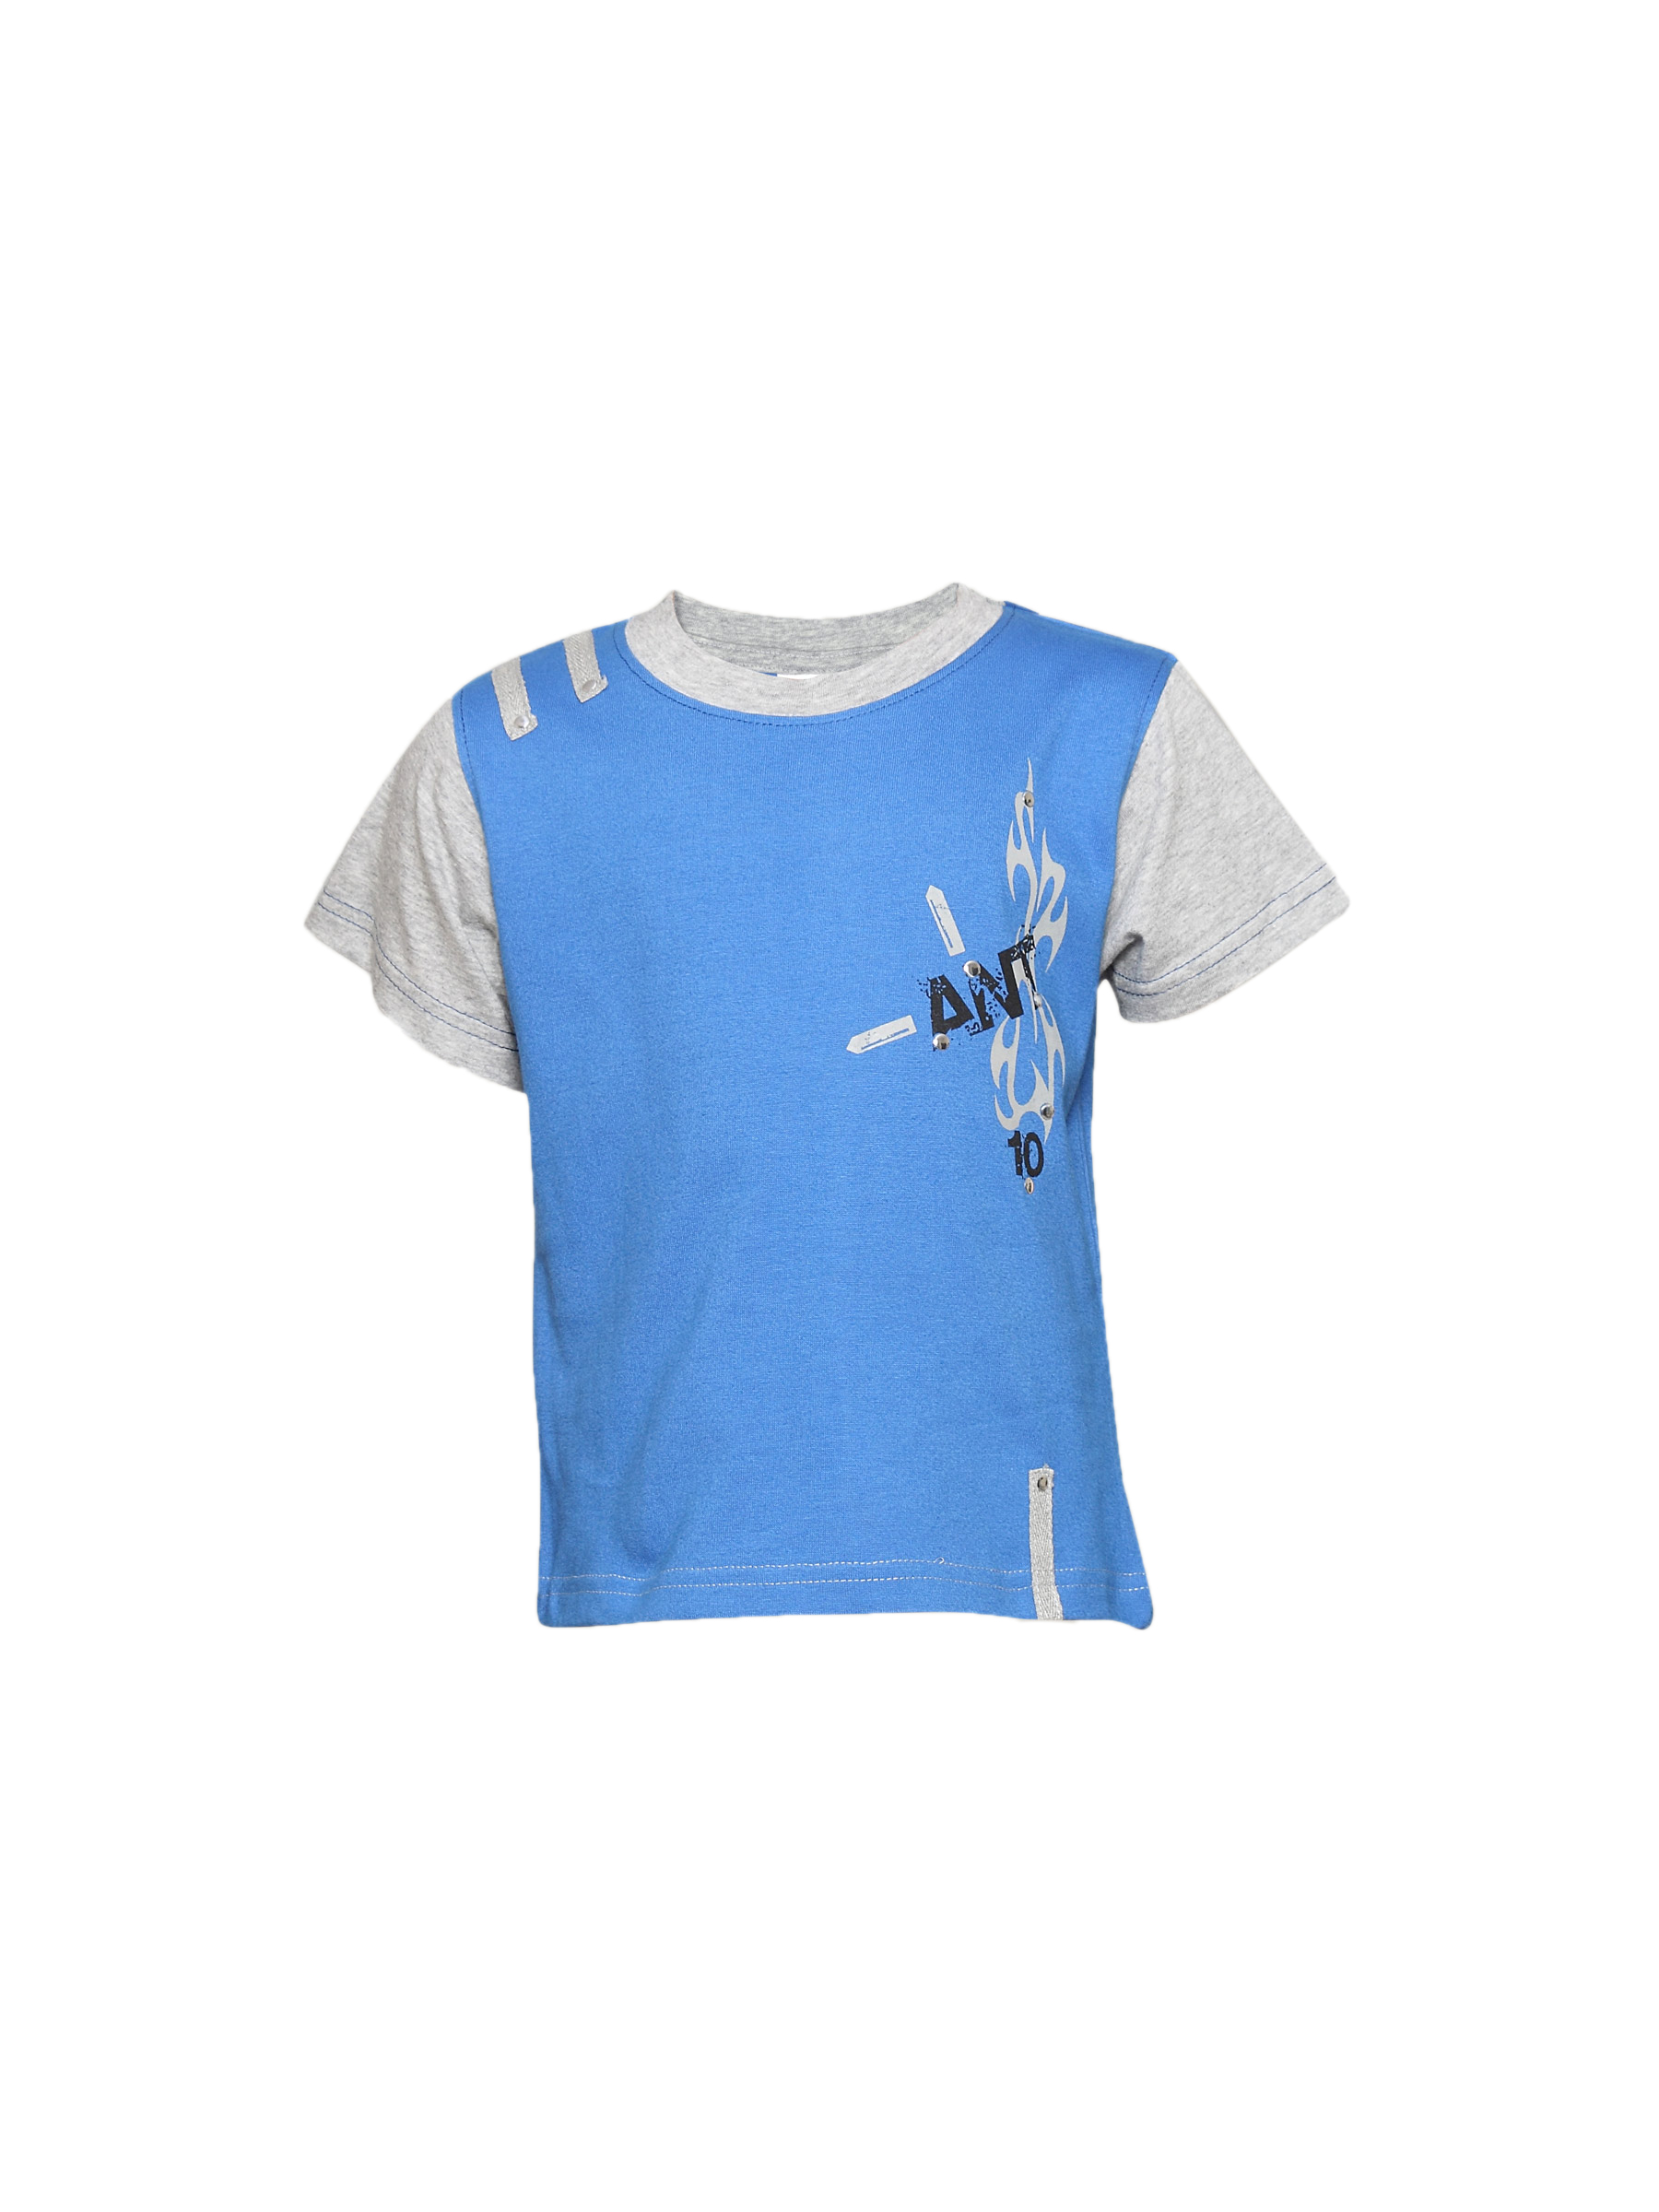

In [103]:
# Try loading one image
from PIL import Image
img_path = os.path.join(image_dir, train_df.iloc[0]['image'])
Image.open(img_path)


# Starting Training 

In [107]:
train_model(model, train_loader, val_loader, epochs=5)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x100352 and 32768x256)

# Convert CNN -> Feature Extractor

In [66]:
class FeatureExtractor(nn.Module):
    def __init__(self, trained_model):
        super().__init__()
        self.features = nn.Sequential(
            trained_model.conv1,
            nn.ReLU(),
            trained_model.pool,
            trained_model.conv2,
            nn.ReLU(),
            trained_model.pool,
            trained_model.conv3,
            nn.ReLU(),
            trained_model.pool
        )
        self.fc = trained_model.fc1  # keep embedding layer

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Initialize Feature Extractor

In [67]:
feature_model = FeatureExtractor(model).to(device)
feature_model.eval()


FeatureExtractor(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=32768, out_features=256, bias=True)
)

# Extract Feature Vectors (CORE STEP)

In [68]:
import numpy as np

def extract_features(model, dataloader):
    features = []
    labels = []
    images = []

    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            emb = model(imgs)
            features.append(emb.cpu().numpy())
            labels.extend(lbls.numpy())

    return np.vstack(features), np.array(labels)


# Extract Embeddings

In [73]:
train_features, train_labels = extract_features(feature_model, train_loader)
print(train_features.shape)


(12663, 256)


# Similarity Computation (RECOMMENDATION ENGINE)

In [69]:
from sklearn.metrics.pairwise import cosine_similarity


# Recommend Function

In [70]:
def recommend(query_feature, feature_db, top_k=5):
    sims = cosine_similarity(query_feature.reshape(1, -1), feature_db)
    top_indices = sims[0].argsort()[-top_k-1:][::-1]
    return top_indices


# Test Recommendation (VISUAL OUTPUT)
### 10.1 Pick Query Image

In [95]:
from PIL import Image

img_path = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/12345.jpg"

query_img = Image.open(img_path).convert("RGB")
query_tensor = transform(query_img).unsqueeze(0).to(device)

with torch.no_grad():
    query_feature = feature_model(query_tensor).cpu().numpy()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x100352 and 32768x256)

In [71]:
query_img, _ = test_ds[10]
query_tensor = query_img.unsqueeze(0).to(device)

with torch.no_grad():
    query_feature = feature_model(query_tensor).cpu().numpy()


In [93]:
query_img

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

# Get Similar Images 

In [74]:
indices = recommend(query_feature, train_features, top_k=5)
indices

array([ 3086,  4524,  1442,  2762, 12660,  5340])

# Display Results

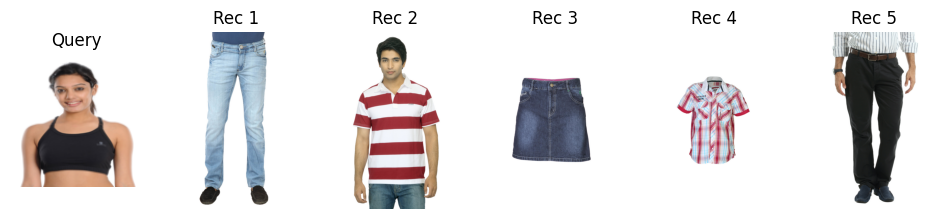

In [94]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# Query
plt.subplot(1,6,1)
plt.imshow(query_img.permute(1,2,0))
plt.title("Query")
plt.axis('off')

# Recommendations
for i, idx in enumerate(indices[:5]):
    img_path = os.path.join(image_dir, train_df.iloc[idx]['image'])
    img = Image.open(img_path)

    plt.subplot(1,6,i+2)
    plt.imshow(img)
    plt.title(f"Rec {i+1}")
    plt.axis('off')

plt.show()


# Downloading the Embeddings

In [76]:
model.eval()


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [77]:
import torch

embeddings_list = []
labels_list = []

def embedding_hook(module, input, output):
    embeddings_list.append(output.detach().cpu())


In [78]:
hook_handle = model.fc1.register_forward_hook(embedding_hook)


In [79]:
embeddings_list.clear()
labels_list.clear()

with torch.no_grad():
    for images, labels in train_loader:   # or test_loader
        images = images.to(device)
        _ = model(images)                 # normal forward pass
        labels_list.append(labels)


In [80]:
import numpy as np

embeddings = torch.cat(embeddings_list, dim=0).numpy()
labels = torch.cat(labels_list, dim=0).numpy()

print("Embeddings shape:", embeddings.shape)
print("Labels shape:", labels.shape)


Embeddings shape: (12663, 256)
Labels shape: (12663,)


In [81]:
hook_handle.remove()


In [82]:
np.save("/kaggle/working/product_embeddings.npy", embeddings)
np.save("/kaggle/working/product_labels.npy", labels)

torch.save(model.state_dict(), "/kaggle/working/simplecnn_model.pth")


In [83]:
import os

print("Files in /kaggle/working:")
print(os.listdir("/kaggle/working"))


Files in /kaggle/working:
['simplecnn_model.pth', 'product_labels.npy', '.virtual_documents', 'product_embeddings.npy']


In [84]:
!zip -r /kaggle/working/embeddings_package.zip \
    /kaggle/working/product_embeddings.npy \
    /kaggle/working/product_labels.npy \
    /kaggle/working/simplecnn_model.pth


  adding: kaggle/working/product_embeddings.npy (deflated 9%)
  adding: kaggle/working/product_labels.npy (deflated 98%)
  adding: kaggle/working/simplecnn_model.pth (deflated 8%)


In [85]:
import gradio as gr
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from sklearn.metrics.pairwise import cosine_similarity


In [86]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [87]:
def extract_features(model, image):
    model.eval()
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        features = model(image)

    return features.cpu().numpy().flatten()


In [88]:
def recommend_products(query_image, top_k=5):
    query_features = extract_features(model, query_image)

    similarities = cosine_similarity(
        [query_features],
        image_embeddings
    )[0]

    top_indices = np.argsort(similarities)[-top_k:][::-1]

    recommended_images = [
        Image.open(image_paths[idx]) for idx in top_indices
    ]

    return recommended_images


In [89]:
def gradio_interface(query_image):
    recommendations = recommend_products(query_image)
    return recommendations


In [90]:
def extract_features(model, image):
    model.eval()
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        features = model(image)

    return features.cpu().numpy().flatten()


In [91]:
def recommend_products(query_image, top_k=5):
    query_features = extract_features(model, query_image)

    similarities = cosine_similarity(
        [query_features],
        image_embeddings
    )[0]

    top_indices = np.argsort(similarities)[-top_k:][::-1]

    recommended_images = [
        Image.open(image_paths[idx]) for idx in top_indices
    ]

    return recommended_images


In [92]:
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("""
    # 👕 Visual Product Recommendation System
    ### CNN-based Image Similarity (From Scratch)
    Upload a fashion product image to get visually similar recommendations.
    """)

    with gr.Row():
        with gr.Column():
            input_image = gr.Image(type="pil", label="Upload Query Image")
            submit_btn = gr.Button("Recommend")

        with gr.Column():
            output_gallery = gr.Gallery(
                label="Recommended Products",
                columns=5,
                height=250
            )

    submit_btn.click(
        fn=gradio_interface,
        inputs=input_image,
        outputs=output_gallery
    )





In [ ]:
demo.launch()

# Doing Model Training and Everything From Scratch

In [193]:
# Kaggle dataset paths
STYLES_CSV = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv'
IMAGES_CSV = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images.csv'
IMAGE_DIR = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images'

# Load CSVs
df_styles = pd.read_csv(STYLES_CSV,
    on_bad_lines='skip',
    encoding='utf-8')
df_images = pd.read_csv(IMAGES_CSV)

# Quick check
print("Styles dataset:", df_styles.shape)
print("Images dataset:", df_images.shape)
df_images.head()



Styles dataset: (44424, 10)
Images dataset: (44446, 2)


filename                                               link
0  15970.jpg  http://assets.myntassets.com/v1/images/style/p...
1  39386.jpg  http://assets.myntassets.com/v1/images/style/p...
2  59263.jpg  http://assets.myntassets.com/v1/images/style/p...
3  21379.jpg  http://assets.myntassets.com/v1/images/style/p...
4  53759.jpg  http://assets.myntassets.com/v1/images/style/p...

In [194]:
df_images['id'] = df_images['filename'].str.replace('.jpg','', regex=False).astype(int)
df_images.head()


filename                                               link     id
0  15970.jpg  http://assets.myntassets.com/v1/images/style/p...  15970
1  39386.jpg  http://assets.myntassets.com/v1/images/style/p...  39386
2  59263.jpg  http://assets.myntassets.com/v1/images/style/p...  59263
3  21379.jpg  http://assets.myntassets.com/v1/images/style/p...  21379
4  53759.jpg  http://assets.myntassets.com/v1/images/style/p...  53759

In [195]:
available_images = set(os.listdir(IMAGE_DIR))
df_images = df_images[df_images['filename'].isin(available_images)].reset_index(drop=True)

print("Number of images we can use:", len(df_images))
df_images.head()


Number of images we can use: 44441


filename                                               link     id
0  15970.jpg  http://assets.myntassets.com/v1/images/style/p...  15970
1  39386.jpg  http://assets.myntassets.com/v1/images/style/p...  39386
2  59263.jpg  http://assets.myntassets.com/v1/images/style/p...  59263
3  21379.jpg  http://assets.myntassets.com/v1/images/style/p...  21379
4  53759.jpg  http://assets.myntassets.com/v1/images/style/p...  53759

In [196]:
# Keep only styles with IDs that have images
df_merged = df_styles[df_styles['id'].isin(df_images['id'])].merge(
    df_images[['id','filename']], on='id', how='inner'
)

print("Dataset after merging metadata with existing images:", df_merged.shape)
df_merged.head()



Dataset after merging metadata with existing images: (44419, 11)


id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName   filename  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  15970.jpg  
1  2012.0  Casual             Peter England Men Party Blue Jeans  39386.jpg  
2  2016.0  Casual                       Titan Women Silver Watch  59263.jpg  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  21379.jpg  
4  2012.0  Casual                          Puma Men Grey T-shirt  53759.jpg

In [197]:
TOP_CATEGORIES = [
    'Topwear', 'Shoes', 'Bags', 'Bottomwear', 'Watches',
    'Innerwear', 'Jewellery', 'Eyewear', 'Fragrance', 'Sandal'
]

df_merged = df_merged[df_merged['subCategory'].isin(TOP_CATEGORIES)].reset_index(drop=True)
print("After filtering top 10 subCategories:", df_merged.shape)



After filtering top 10 subCategories: (36965, 11)


In [198]:
label_encoder = LabelEncoder()
df_merged['label'] = label_encoder.fit_transform(df_merged['subCategory'])
num_classes = df_merged['label'].nunique()
print("Number of classes:", num_classes)
df_merged[['subCategory','label']].head()



Number of classes: 10


subCategory  label
0     Topwear      8
1  Bottomwear      1
2     Watches      9
3  Bottomwear      1
4     Topwear      8

In [199]:
train_df, val_df = train_test_split(
    df_merged,
    test_size=0.2,
    stratify=df_merged['label'],
    random_state=42
)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))



Train size: 29572
Validation size: 7393


In [200]:
BATCH_SIZE = 32
IMAGE_SIZE = (128,128)  # You can increase to (224,224) if GPU allows

def image_generator(df, image_dir, batch_size=BATCH_SIZE):
    while True:
        df = df.sample(frac=1).reset_index(drop=True)
        for i in range(0, len(df), batch_size):
            batch = df.iloc[i:i+batch_size]
            
            images = []
            labels = []
            
            for _, row in batch.iterrows():
                img_name = row['filename']
                img_path = os.path.join(image_dir, img_name)
                
                # Skip missing files
                if not os.path.exists(img_path):
                    continue
                
                # Load image
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE)
                img = tf.keras.preprocessing.image.img_to_array(img)
                img = img / 255.0

                images.append(img)
                labels.append(row['label'])
            
            if len(images) == 0:
                continue
            yield np.array(images), tf.keras.utils.to_categorical(labels, num_classes=num_classes)


In [202]:
# Basic libraries
import pandas as pd
import numpy as np
import os

# For train/validation split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# For CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,930 (12.61 MB)

 Trainable params: 3,305,930 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [203]:
EPOCHS = 10  # Start small
train_gen = image_generator(train_df, IMAGE_DIR)
val_gen = image_generator(val_df, IMAGE_DIR)

steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(val_df) // BATCH_SIZE

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=EPOCHS
)


Epoch 1/10


I0000 00:00:1768563445.843413     303 service.cc:152] XLA service 0x799720005860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768563445.843450     303 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768563446.186274     303 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/924 ━━━━━━━━━━━━━━━━━━━━ 1:09:46 5s/step - accuracy: 0.0312 - loss: 2.3221

I0000 00:00:1768563448.938986     303 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


924/924 ━━━━━━━━━━━━━━━━━━━━ 1029s 1s/step - accuracy: 0.8365 - loss: 0.5571 - val_accuracy: 0.9555 - val_loss: 0.1525
Epoch 2/10
924/924 ━━━━━━━━━━━━━━━━━━━━ 721s 779ms/step - accuracy: 0.9559 - loss: 0.1472 - val_accuracy: 0.9713 - val_loss: 0.0921
Epoch 3/10
924/924 ━━━━━━━━━━━━━━━━━━━━ 694s 752ms/step - accuracy: 0.9709 - loss: 0.0979 - val_accuracy: 0.9775 - val_loss: 0.0849
Epoch 4/10
924/924 ━━━━━━━━━━━━━━━━━━━━ 679s 735ms/step - accuracy: 0.9788 - loss: 0.0715 - val_accuracy: 0.9800 - val_loss: 0.0760
Epoch 5/10
924/924 ━━━━━━━━━━━━━━━━━━━━ 715s 775ms/step - accuracy: 0.9825 - loss: 0.0538 - val_accuracy: 0.9800 - val_loss: 0.0802
Epoch 6/10
924/924 ━━━━━━━━━━━━━━━━━━━━ 696s 754ms/step - accuracy: 0.9854 - loss: 0.0464 - val_accuracy: 0.9815 - val_loss: 0.0680
Epoch 7/10
924/924 ━━━━━━━━━━━━━━━━━━━━ 663s 719ms/step - accuracy: 0.9860 - loss: 0.0411 - val_accuracy: 0.9823 - val_loss: 0.0752
Epoch 8/10
924/924 ━━━━━━━━━━━━━━━━━━━━ 637s 690ms/step - accuracy: 0.9889 - loss: 0.0336

In [209]:
import numpy as np

# Create a single dummy image with the same shape as your model expects
dummy_input = np.random.rand(1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)  # batch size = 1

# Run the dummy input through your already trained model
_ = model.predict(dummy_input)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


In [210]:
from tensorflow.keras.models import Model

# Exclude the last Dense layer (softmax)
feature_model = Model(inputs=model.input, outputs=model.layers[-3].output)
feature_model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     3,211,392 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,640 (12.61 MB)

 Trainable params: 3,304,640 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [212]:
embeddings = []
for path in df_merged['filename']:
    embeddings.append(get_embedding(path))
embeddings = np.array(embeddings)


NameError: name 'get_embedding' is not defined

In [214]:
import numpy as np

# Build the Sequential model by running a dummy image
dummy_input = np.random.rand(1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)  # batch size = 1
_ = model.predict(dummy_input)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [215]:
from tensorflow.keras.models import Model

# Use the second-last layer as embedding
feature_model = Model(inputs=model.input, outputs=model.layers[-3].output)
feature_model.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     3,211,392 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,640 (12.61 MB)

 Trainable params: 3,304,640 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [216]:
IMAGE_DIR = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images'

df_merged['img_path'] = df_merged['filename'].apply(lambda x: os.path.join(IMAGE_DIR, x))


In [217]:
def get_embedding(img_path):
    import tensorflow as tf
    import numpy as np

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    embedding = feature_model.predict(img, verbose=0)
    return embedding[0]


In [218]:
from tqdm import tqdm
embeddings = []

for path in tqdm(df_merged['img_path'], desc="Generating embeddings"):
    embeddings.append(get_embedding(path))

embeddings = np.array(embeddings)  # shape: (num_images, 128)
print("Embeddings shape:", embeddings.shape)


Generating embeddings: 100%|██████████| 36965/36965 [52:27<00:00, 11.74it/s]  

Embeddings shape: (36965, 128)


In [219]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_similar(img_path, embeddings, df, top_k=5):
    query_emb = get_embedding(img_path).reshape(1, -1)
    similarities = cosine_similarity(query_emb, embeddings)[0]
    top_idx = similarities.argsort()[-top_k:][::-1]
    return df.iloc[top_idx]


In [233]:
df_merged

id gender masterCategory subCategory            articleType  \
0      15970    Men        Apparel     Topwear                 Shirts   
1      39386    Men        Apparel  Bottomwear                  Jeans   
2      59263  Women    Accessories     Watches                Watches   
3      21379    Men        Apparel  Bottomwear            Track Pants   
4      53759    Men        Apparel     Topwear                Tshirts   
...      ...    ...            ...         ...                    ...   
36960  42234  Women        Apparel     Topwear                   Tops   
36961  17036    Men       Footwear       Shoes           Casual Shoes   
36962  18842    Men        Apparel     Topwear                Tshirts   
36963  46694  Women  Personal Care   Fragrance  Perfume and Body Mist   
36964  51623  Women    Accessories     Watches                Watches   

      baseColour  season    year   usage  \
0      Navy Blue    Fall  2011.0  Casual   
1           Blue  Summer  2012.0  Casual   
2         Silver  Winter  2016.0  Casual   
3          Black    Fall  2011.0  Casual   
4           Grey  Summer  2012.0  Casual   
...          ...     ...     ...     ...   
36960       Blue  Summer  2012.0  Casual   
36961      White  Summer  2013.0  Casual   
36962       Blue    Fall  2011.0  Casual   
36963       Blue  Spring  2017.0  Casual   
36964       Pink  Winter  2016.0  Casual   

                                    productDisplayName   filename  label  \
0                     Turtle Check Men Navy Blue Shirt  15970.jpg      8   
1                   Peter England Men Party Blue Jeans  39386.jpg      1   
2                             Titan Women Silver Watch  59263.jpg      9   
3        Manchester United Men Solid Black Track Pants  21379.jpg      1   
4                                Puma Men Grey T-shirt  53759.jpg      8   
...                                                ...        ...    ...   
36960                     Sepia Women Blue Printed Top  42234.jpg      8   
36961                        Gas Men Caddy Casual Shoe  17036.jpg      7   
36962             Puma Men Graphic Stellar Blue Tshirt  18842.jpg      8   
36963                   Rasasi Women Blue Lady Perfume  46694.jpg      3   
36964  Fossil Women Pink Dial Chronograph Watch ES3050  51623.jpg      9   

                                                img_path  
0      /kaggle/input/fashion-product-images-dataset/f...  
1      /kaggle/input/fashion-product-images-dataset/f...  
2      /kaggle/input/fashion-product-images-dataset/f...  
3      /kaggle/input/fashion-product-images-dataset/f...  
4      /kaggle/input/fashion-product-images-dataset/f...  
...                                                  ...  
36960  /kaggle/input/fashion-product-images-dataset/f...  
36961  /kaggle/input/fashion-product-images-dataset/f...  
36962  /kaggle/input/fashion-product-images-dataset/f...  
36963  /kaggle/input/fashion-product-images-dataset/f...  
36964  /kaggle/input/fashion-product-images-dataset/f...  

[36965 rows x 13 columns]

In [238]:
# Pick a query image
query_image = df_merged['img_path'].iloc[0]

print("Query product:")
print(df_merged.iloc[0][['subCategory','productDisplayName','filename']])

recommendations = recommend_similar(query_image, embeddings, df_merged, top_k=5)

print("\nTop 5 similar products:")
print(recommendations[['subCategory','productDisplayName','filename']])


Query product:
subCategory                                    Topwear
productDisplayName    Turtle Check Men Navy Blue Shirt
filename                                     15970.jpg
Name: 0, dtype: object

Top 5 similar products:
      subCategory                          productDisplayName   filename
0         Topwear            Turtle Check Men Navy Blue Shirt  15970.jpg
1384      Topwear               Scullers Men Scul Blue Shirts   9266.jpg
29585     Topwear             Highlander Men Check Blue Shirt  16031.jpg
35905     Topwear  Manchester United Men Printed White Tshirt  18245.jpg
26002     Topwear             Highlander Men Check Blue Shirt  16025.jpg


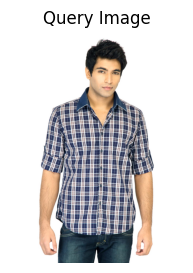

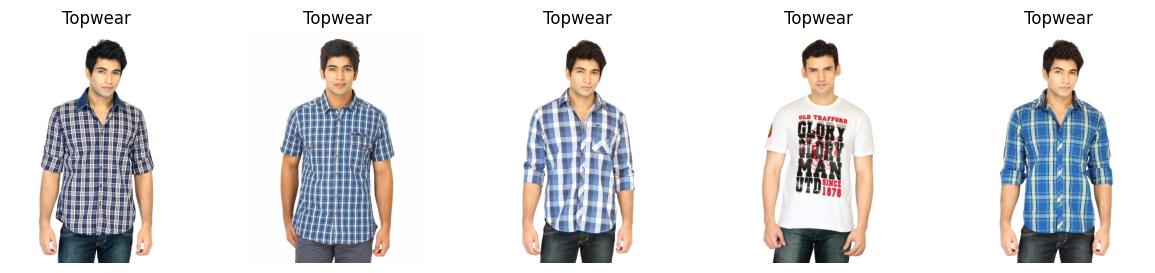

In [239]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Query image
plt.figure(figsize=(3,3))
img = mpimg.imread(query_image)
plt.imshow(img)
plt.title("Query Image")
plt.axis('off')
plt.show()

# Recommended images|
plt.figure(figsize=(15,3))
for i, row in enumerate(recommendations.itertuples()):
    plt.subplot(1,5,i+1)
    img = mpimg.imread(row.img_path)
    plt.imshow(img)
    plt.title(row.subCategory)
    plt.axis('off')
plt.show()


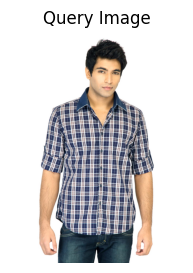

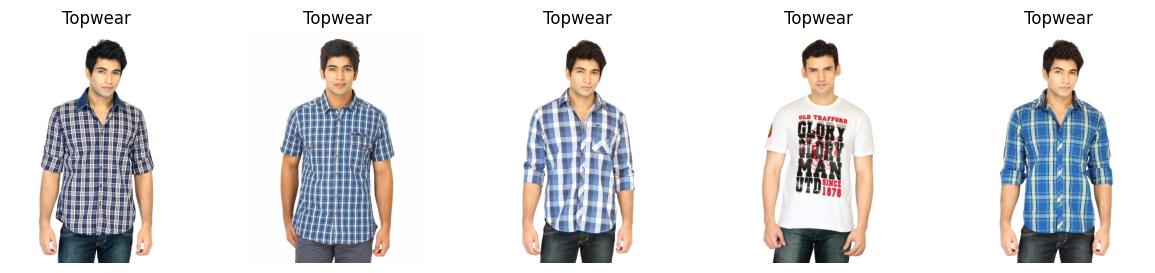

In [222]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Query image
plt.figure(figsize=(3,3))
img = mpimg.imread(query_image)
plt.imshow(img)
plt.title("Query Image")
plt.axis('off')
plt.show()

# Recommended images
plt.figure(figsize=(15,3))
for i, row in enumerate(recommendations.itertuples()):
    plt.subplot(1,5,i+1)
    img = mpimg.imread(row.img_path)
    plt.imshow(img)
    plt.title(row.subCategory)
    plt.axis('off')
plt.show()


In [223]:
import gradio as gr
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [226]:
def recommend_products(uploaded_img, top_k=5):
    """
    uploaded_img: PIL image from Gradio
    top_k: number of recommendations
    """
    # Save uploaded image temporarily
    uploaded_img_path = "/tmp/query.jpg"
    uploaded_img.save(uploaded_img_path)

    # Get top-K recommendations
    recs = recommend_similar(uploaded_img_path, embeddings, df_merged, top_k=top_k)

    # Prepare images and captions
    imgs = []
    captions = []
    for row in recs.itertuples():
        img = mpimg.imread(row.img_path)
        imgs.append(img)
        captions.append(f"{row.subCategory}\n{row.productDisplayName[:30]}...")  # short name

    return imgs, captions


In [229]:
import gradio as gr

# If you want a gallery with captions, just pass the list of images and captions directly
interface = gr.Interface(
    fn=recommend_products,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Gallery(label="Recommended Products"),  # no .style()
             gr.Textbox(label="Product Names")],
    title="Fashion Product Recommendation",
    description="Upload an image and get top visually similar products."
)

interface.launch()



* Running on local URL:  http://127.0.0.1:7861
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://f3bc44a2a7d231edfb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


KeyboardInterrupt: 

In [230]:
# -------------------------------
# Gradio-based Image Recommendation
# -------------------------------

import gradio as gr
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf

# Make sure the CNN is "built" (needed for Sequential models)
dummy_input = np.random.rand(1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
_ = model.predict(dummy_input)

# Feature extractor (exclude last Dense layer)
from tensorflow.keras.models import Model
feature_model = Model(inputs=model.input, outputs=model.layers[-3].output)

# Function to get embedding from an image path
def get_embedding(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    emb = feature_model.predict(img, verbose=0)
    return emb[0]

# Function to recommend top-K similar products
from sklearn.metrics.pairwise import cosine_similarity

def recommend_similar(img_path, embeddings, df, top_k=5):
    query_emb = get_embedding(img_path).reshape(1, -1)
    similarities = cosine_similarity(query_emb, embeddings)[0]
    top_idx = similarities.argsort()[-top_k:][::-1]
    return df.iloc[top_idx]

# Gradio interface function
def recommend_products(uploaded_img, top_k=5):
    # Save uploaded image temporarily
    uploaded_img_path = "/tmp/query.jpg"
    uploaded_img.save(uploaded_img_path)

    # Get top-K recommendations
    recs = recommend_similar(uploaded_img_path, embeddings, df_merged, top_k=top_k)

    # Prepare images and captions
    imgs = []
    captions = []
    for row in recs.itertuples():
        img = mpimg.imread(row.img_path)
        imgs.append(img)
        captions.append(f"{row.subCategory}: {row.productDisplayName[:30]}...")  # short name

    # Combine captions for textbox
    captions_text = "\n".join(captions)
    return imgs, captions_text

# Launch Gradio
interface = gr.Interface(
    fn=recommend_products,
    inputs=[gr.Image(type="pil"), gr.Slider(1, 10, value=5, step=1, label="Number of recommendations")],
    outputs=[gr.Gallery(label="Recommended Products"), gr.Textbox(label="Product Names")],
    title="Fashion Product Recommendation",
    description="Upload an image and get visually similar product recommendations."
)

interface.launch()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
* Running on local URL:  http://127.0.0.1:7862
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://4ff43403e6a2e5c554.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


KeyboardInterrupt: 